In [6]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb
import inspect
import h5py
import time
import matplotlib.pyplot as plt 
from matplotlib import gridspec

# Filling algorithm

Different from covering algorithm, technically more correct at the moment; instead of checking every point individually for each orbit it finds the orbit which minimizes the cost function at each point; i.e. orbit vs. orbit comparison.  

The following are some assorted cost functions tested for the purpose of filling.

In [7]:
minimal_orbits = orb.read_h5('./data/minimal_cover.h5')
large_patch = orb.read_h5('./data/large_patches.h5', '0/')

In [8]:
# Get the less strict thresholds
strictness = 0
critical_l2_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference_mean_flow_correction'][...][strictness])

critical_l2_diff_values_fd = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values_fd.append(file['defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['drifter/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['large_defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['wiggle/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])

windows = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=False)) for x in minimal_orbits]
windows_fd = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=True)) for x in minimal_orbits]
windows_total = [x for y in windows+windows_fd for x in y]

cvalues = [len(windows[i])*[critical_l2_diff_values[i]/windows[i][0].size] for i in range(len(windows))]
cvalues_fd = [len(windows_fd[i])*[critical_l2_diff_values_fd[i]/windows_fd[i][0].size] for i in range(len(windows_fd))]
# cvalues_density = [x for y in cvalues+cvalues_fd for x in y]
# cvalues_total = [windows_total[i].size * cvalues_density[i] for i in range(len(windows_total))]
cvalues = critical_l2_diff_values + critical_l2_diff_values_fd
windows = minimal_orbits + [x.to_fundamental_domain() for x in minimal_orbits]
window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)    

First, for the preliminary test runs, produce the set of orbits and the corresponding threshold values

# Strict threshold runs

The runs I make:

With equally sized orbits:
1. $L_2$ difference density with masking/subtracting the filled portion of the field 
2. $L_2$ difference density without masking/subtracting the filled portion of the field 
3. Same as (1) but with 'mean flow correction'
4. Same as (2) but with 'mean flow correction'

If this does not yield good results, reduce the strictness from 0.01 percentile to 0.1 percentile. 
If the decrease of strictness does not help, then look towards actually resizing the orbits (currently crude
sizes are used, not relative to one another). 

The mean flow correction doesn't really make sense when the shadowing slice being considered isn't a rectangular shape, as
it is based on the mean spatial it originates from spatial mean = 0 constraint.

----------------------------------------------------------------------------------------------------Large patch filling took 0.16 minutes to complete


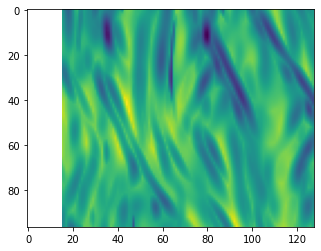

In [9]:
minimal_orbits = orb.read_h5('./data/minimal_cover.h5')
base = orb.read_h5('./data/large_patches.h5', '0/')
base = orb.read_h5('./data/small_patches.h5', '0/')

# Get the less strict thresholds
strictness = 0
critical_l2_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference_mean_flow_correction'][...][strictness])

critical_l2_diff_values_fd = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values_fd.append(file['defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['drifter/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['large_defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['wiggle/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])

windows = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=False)) for x in minimal_orbits]
windows_fd = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=True)) for x in minimal_orbits]
windows_total = [x for y in windows+windows_fd for x in y]

cvalues = [len(windows[i])*[critical_l2_diff_values[i]/windows[i][0].size] for i in range(len(windows))]
cvalues_fd = [len(windows_fd[i])*[critical_l2_diff_values_fd[i]/windows_fd[i][0].size] for i in range(len(windows_fd))]
# cvalues_density = [x for y in cvalues+cvalues_fd for x in y]
# cvalues_total = [windows_total[i].size * cvalues_density[i] for i in range(len(windows_total))]
cvalues = critical_l2_diff_values + critical_l2_diff_values_fd
windows = minimal_orbits + [x.to_fundamental_domain() for x in minimal_orbits]
window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)    

scrfunc = orb.scoring_functions('l2_density_mfc')
# windows = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=False)) for x in minimal_orbits]
# windows_fd = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=True)) for x in minimal_orbits]
# windows_total = [x for y in windows+windows_fd for x in y]
# cvalues = [len(windows[i])*[critical_l2_diff_values[i]/windows[i][0].size] for i in range(len(windows))]
# cvalues_fd = [len(windows_fd[i])*[critical_l2_diff_values_fd[i]/windows_fd[i][0].size] for i in range(len(windows_fd))]
# cvalues_density = [x for y in cvalues+cvalues_fd for x in y]
# cvalues_total = [windows_total[i].size * cvalues_density[i] for i in range(len(windows_total))]
windows = minimal_orbits + [x.to_fundamental_domain() for x in minimal_orbits]
cvalues = critical_l2_diff_values + critical_l2_diff_values_fd
cvalues = [c/w.size for c, w in zip(cvalues, windows)]
    # window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)

t0l0=time.time_ns()/10**9
base_orbit_periodicity=(False, True)
pivot_scores, weights = orb.fill(base, windows, cvalues,
                         scoring_function=scrfunc,
                         min_overlap=1,
                         replacement=False,
                         base_orbit_periodicity=base_orbit_periodicity,
                         verbose=True)
t1l0=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l0-t0l0)/60.))

plt.imshow(orb.process_scores(pivot_scores.reshape((1, *pivot_scores.shape)),
                              base, windows[-1], base_orbit_periodicity).squeeze())

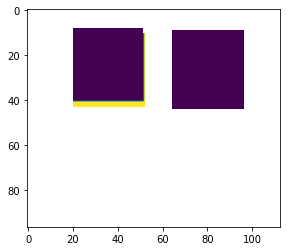

In [10]:
plt.imshow(weights)

Preview/visualization of results with strict threshold. 

# Heterogeneous discretizations

In [66]:
base_orbits = [y for y in  read_h5('./data/small_patches.h5')]

t0fam=time.time_ns()/10**9
mean_flow_masks = []
mean_flow_weights = []
for base in base_orbits:
    print('#', end='')
    _, m, w = fill(base, cvalues_mean_flow_total, windows_total,
                    scoring_function=l2_difference_mean_flow_correction,
                    base_orbit_periodicity=(False, False),
                    verbose=False, subtract_field=False)
    mean_flow_masks.append(m)
    mean_flow_weights.append(w)
t1fam=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1fam-t0fam)/60.))

Export and save the data because it took so long to complete. Commented out to prevent accidental overwrites. 